In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from matplotlib import pyplot as plt
import numpy as np
from scipy import io
from sklearn import metrics

from yass.augment import make
from pathlib import Path
from statsmodels.tsa.stattools import acf

import yass
from yass.neuralnetwork import NeuralNetDetector, NeuralNetTriage
from yass import set_config, read_config
from yass.templates import TemplatesProcessor
from yass.neuralnetwork.evaluate import Dataset
from yass.neuralnetwork import evaluate
from yass.augment import util as augment_util
from yass.augment import noise as noise_utils

import seaborn as sns
import pandas as pd
from dstools import plot
from keras.models import load_model

Using TensorFlow backend.


## Load model

In [3]:
yass.set_config("../config/gcloud/49/default.yaml")
CONFIG = read_config()

path_to_model_ref = '/home/Edu/shengao-aug1/detect.ckpt'
# path_to_model_ref = '/home/Edu/cat-july19/detect.ckpt'

path_to_model = '/home/Edu/dev/private-yass/nnet/models/detect/09-Aug-2018@02-02-17.ckpt'
# path_to_model = 'detect-09-Aug-2018@01-54-51.h5'

# path_to_model = path_to_model_ref

# path_to_model = '/home/Edu/shengao-aug1/detect.ckpt'

THRESHOLD = 0.5

try:
    model = NeuralNetDetector.load(path_to_model, 0.5, CONFIG.channel_index)
except:
    model = load_model(path_to_model)
    

try:
    model_ref = load_model(path_to_model_ref)
except:
    model_ref = NeuralNetDetector.load(path_to_model_ref, THRESHOLD,
                                       CONFIG.channel_index, load_test_set=False, )

## Template loading

In [4]:
path_to_ground_truth = str(Path('~/data/groundtruth_ej49_data1_set1.mat').expanduser())

kk = io.loadmat(path_to_ground_truth)

# L_gt has length total number of spikes; it is the cluster index for each spike
# spt_gt has length total number of spikes; it is the time for each spike
L_gt = kk['L_gt']-1
spt_gt = kk['spt_gt'] + 10
spike_train = np.concatenate((spt_gt, L_gt),axis=1)

min_amp = 2
max_amp = 60
n_clean_per_template = 400 * 5


path_to_standarized = str(Path('~/data/retinal/default/preprocess/standarized.bin').expanduser())

chosen_templates = [0, 1, 2, 3, 4, 5, 7, 8, 9, 11, 12, 13,
                    14, 15, 16, 17, 18, 19, 22, 23, 24, 25,
                    26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
                    36, 37, 38, 39, 41, 42, 43, 44, 45, 46,
                    47, 48]

n_templates = np.max(spike_train[:,1]) + 1
chosen_templates = np.arange(n_templates)

In [63]:
processor = TemplatesProcessor.from_spike_train(CONFIG,
                                                4 * CONFIG.spike_size,
                                                spike_train,
                                                path_to_standarized)

100%|██████████| 23/23 [00:07<00:00,  2.98it/s]


In [64]:
aligned = processor.align(CONFIG.spike_size)

In [65]:
cropped = processor.crop_spatially(CONFIG.neigh_channels, CONFIG.geom)

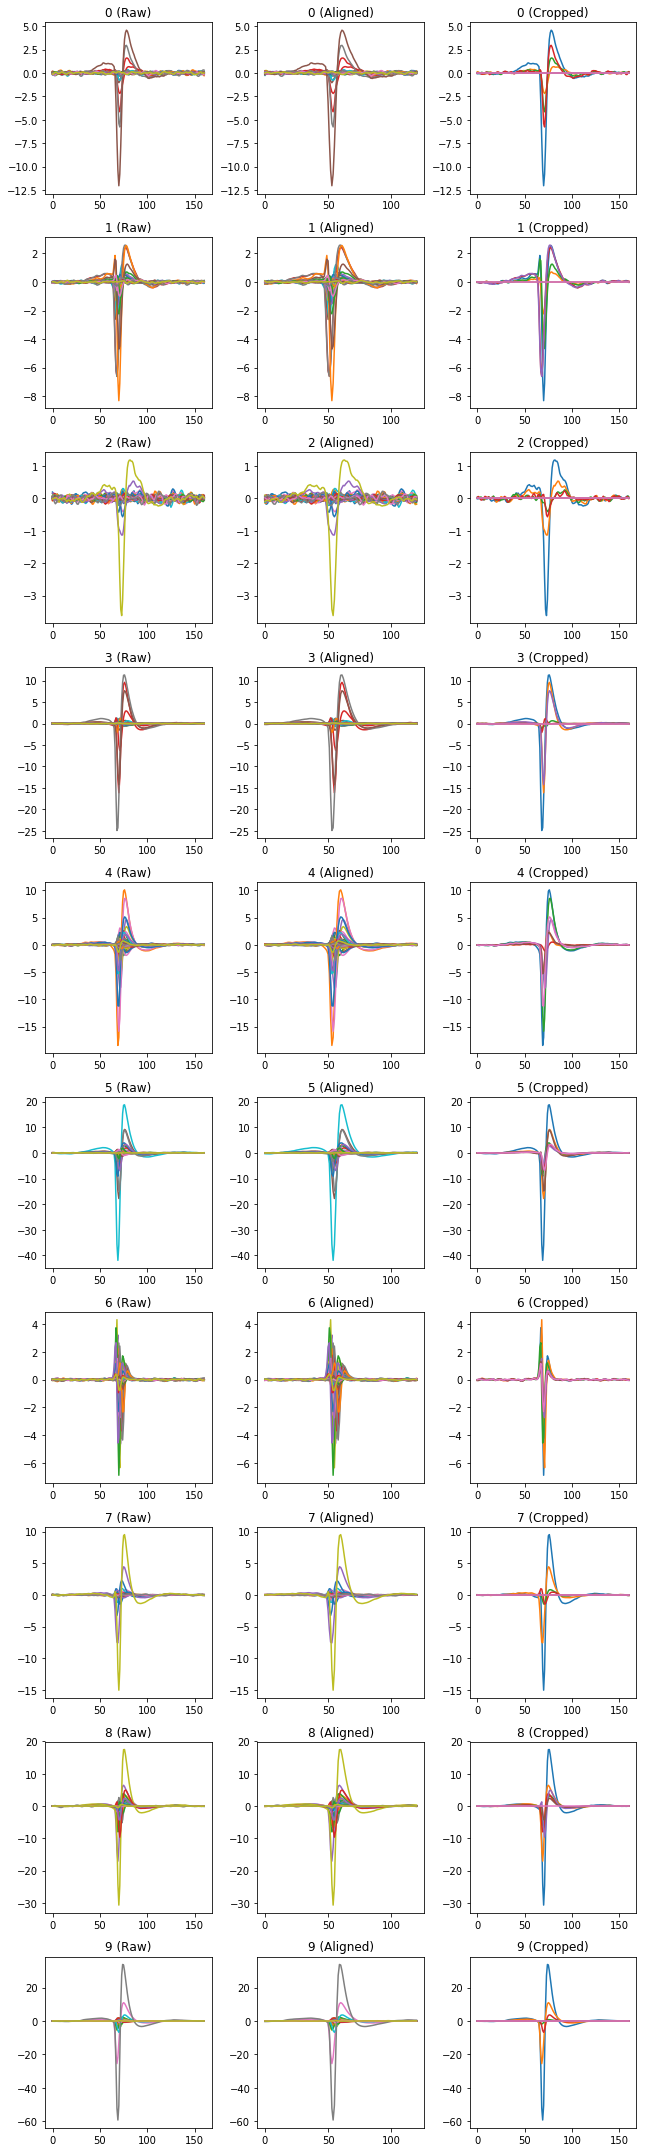

In [66]:
plot.grid_from_array([processor.values,
                      aligned.values, cropped.values],
                     axis=0,
                     elements=range(10),
                     auto_figsize=3,
                     group_names=('Raw', 'Aligned', 'Cropped'))

In [67]:
small = cropped.crop_temporally(30)
small.values.shape

(49, 61, 7)

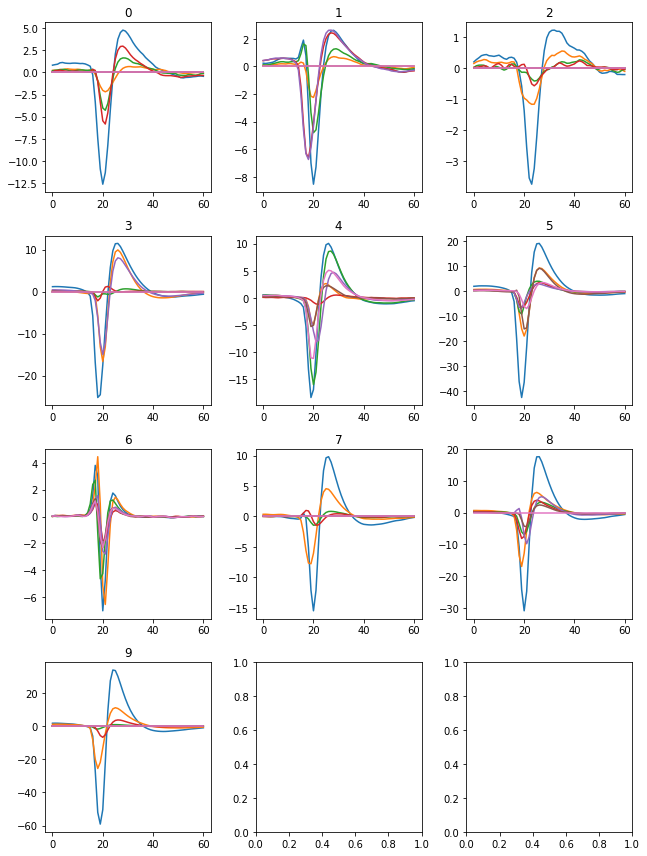

In [12]:
plot.grid_from_array(small.values,
                     axis=0,
                     elements=range(10),
                     auto_figsize=3)

## Generate testing data

In [137]:
# use cat templates
from os.path import expanduser
from yass.templates import TemplatesProcessor

SPIKES_LENGTH = 20

_ = np.load(expanduser('~/cat-templates-processed.npy'))
processor = TemplatesProcessor(_)

templates = processor.crop_temporally(SPIKES_LENGTH).values

In [138]:
templates.shape

(84, 41, 7)

In [139]:
dataset = Dataset.make(units_per_bin=0.5,
                       include_clean_data=False,
                       templates=templates,
                       min_amplitude=min_amp,
                       max_amplitude=max_amp,
                       path_to_data=path_to_standarized,
                       n_per_template=n_clean_per_template,
                       geom=CONFIG.geom,
                       make_from_templates=True,
                       make_spatially_misaligned=False,
                       make_temporally_misaligned=False,
                       make_collided=False,
                       make_noise=True)

In [111]:
dataset.stats

{'from templates': 168000, 'noise': 168000}

In [112]:
dataset.df.head()

,waveform,amplitude,kind,ptp,amplitude_group,ptp_group
0,"[[-0.6649641695205043, -0.7444589157645737, -0...",3.373905,from templates,5.648370,3.399,5.686
1,"[[1.0067061045373764, 2.996087457795185, 0.159...",2.996087,from templates,5.232748,3.005,5.242
2,"[[-1.3272513030301076, -0.29186258538752297, -...",3.075773,from templates,4.959282,3.090,4.967
3,"[[0.851175856922442, 0.2100845023932828, -0.03...",2.859791,from templates,5.123632,2.866,5.130
4,"[[0.026563228589741014, -0.5515645593907621, -...",3.183640,from templates,5.342172,3.196,5.344


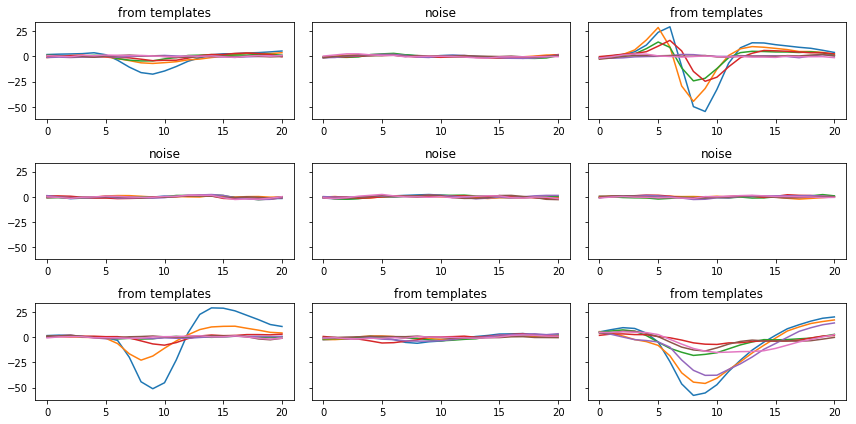

In [113]:
plot.grid_from_array(dataset.data, axis=0,
                     elements=9,
                     labels=dataset.df.kind,
                     auto_figsize=(4, 2),
                     sharey=True)

## Predict on templates

In [140]:
model, model_ref

(<yass.neuralnetwork.model_detector.NeuralNetDetector at 0x7f4316eca5c0>,
 <yass.neuralnetwork.model_detector.NeuralNetDetector at 0x7f4316a99e80>)

In [142]:
preds = ['{:.2f}'.format(p) for p in np.squeeze(model.predict_proba(templates))]
# preds = ['{:.2f}'.format(p) for p in np.squeeze(model.predict_proba(templates[:, :, :, np.newaxis]))]

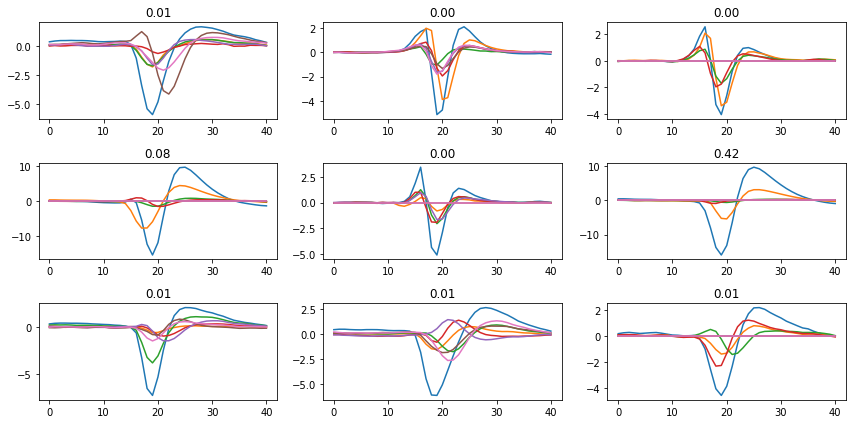

In [143]:
plot.grid_from_array(templates,
                     axis=0,
                     elements=9,
                     auto_figsize=(4, 2),
                     labels=preds,
                     sharey=False)

## Predicting on shifted waveforms

In [35]:
all_channels = aligned.crop_temporally(20)
model.predict_recording(all_channels.values[0])

NameError: name 'aligned' is not defined

In [121]:
def shifter_generator(x, waveform_length, step):
    original_wf_length, n_channels = x.shape    
    n = int((original_wf_length - waveform_length)/step + 1)

    shifted = np.zeros((n, waveform_length, n_channels))
    
    for i in range(n):
        shifted[i, :, :] = x[(i * step):waveform_length + (i * step), :]
    
    return shifted

def predict_plot(model, x):
    preds = ['{:.2f}'.format(p) for p in model.predict(x)]

    plot.grid_from_array(x,
                         axis=0,
                         auto_figsize=3,
                         labels=preds)


def shift_predict_plot(x, waveform_length, step, model):
    shifted = shifter_generator(x, waveform_length, step)
    predict_plot(model, shifted)

In [122]:
cropped.values[0].shape

(161, 7)

In [123]:
# shifted = shifter_generator(cropped.values[0], 41, step=4)

names = ('spike_index', 'probability', 'waveform')
spike_index, prob, wave = model.predict_recording(cropped.values[0],
                                                  output_names=names)

In [124]:
spike_index.shape, prob.shape, wave.shape

((10, 2), (161, 49), (10, 61, 19))

In [125]:
spike_index

array([[74,  4],
       [74,  5],
       [75,  0],
       [75,  1],
       [75,  2],
       [75,  3],
       [75,  7],
       [75, 11],
       [75, 14],
       [75, 15]], dtype=int32)

In [126]:
cropped.values[0].shape

(161, 7)

In [127]:
prob.shape

(161, 49)

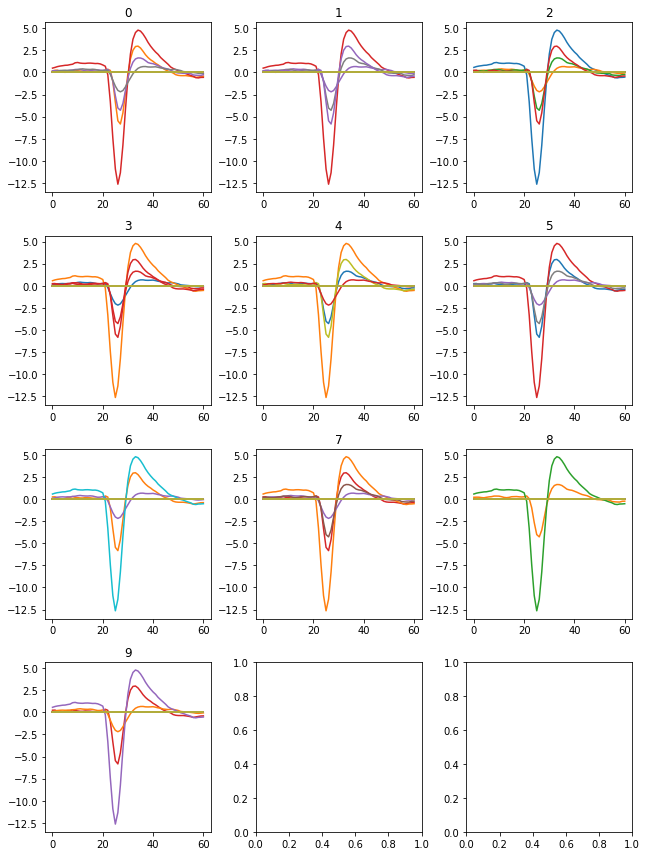

In [128]:
plot.grid_from_array(wave, axis=0, auto_figsize=3)

In [129]:
shift_predict_plot(cropped.values[0], 41, step=4, model=model)

ValueError: waveform length from network (61) does not match input data (41)

## Mean incorrectly classified noise waveform

In [62]:
n_noise = 100000
temporal_size = small.values.shape[1]
n_channels = small.values.shape[2]

(spatial_sig,
 temporal_sig) = (noise_utils.
                  noise_cov(path_to_standarized, CONFIG.neigh_channels,
                            CONFIG.geom, temporal_size))

In [63]:
noise = augment_util.make_noise((n_noise, temporal_size, n_channels),
                                spatial_sig,
                                temporal_sig)

print('Noise shape:', noise.shape)

Noise shape: (100000, 61, 7)


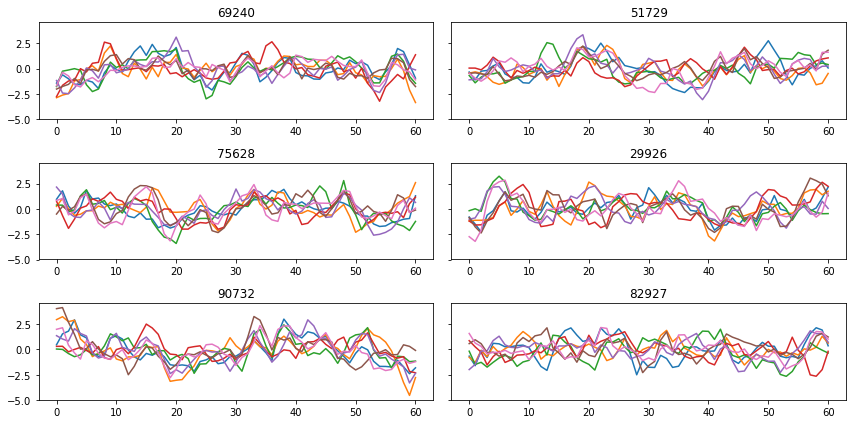

In [64]:
plot.grid_from_array(noise, axis=0, elements=6,
                     auto_figsize=(6, 2), sharey=True)

In [65]:
probas = model.predict_proba(noise)

In [66]:
higher_than_zero = noise[probas > 0.01]
higher_than_one_half = noise[probas > 0.5]

fpr = len(higher_than_one_half)/n_noise

print('{} ({:.4f}) [>0.01], {} ({:.4f})[>0.5]'.format(len(higher_than_zero), len(higher_than_zero)/n_noise,
                                              len(higher_than_one_half), fpr))

2372 (0.0237) [>0.01], 282 (0.0028)[>0.5]


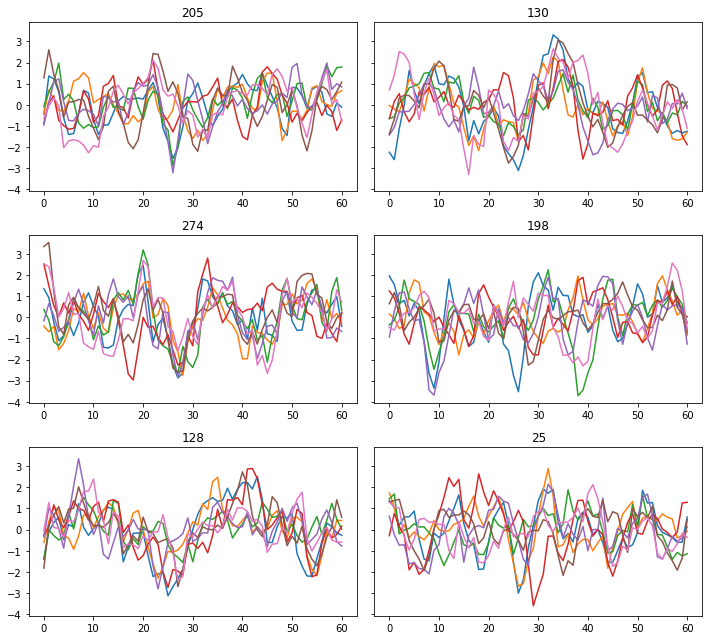

In [67]:
plot.grid_from_array(higher_than_one_half,
                     axis=0,
                     auto_figsize=(5, 3),
                     sharey=True,
                     elements=6)

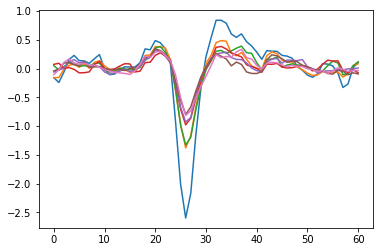

In [68]:
noise_mean_wf = higher_than_one_half.mean(axis=0)
_ = plt.plot(noise_mean_wf)

## Large snippet noise

In [4]:
from yass.batch import RecordingsReader

In [7]:
data = RecordingsReader(path_to_standarized, loader='array').data

In [8]:
# kill signal
data[(data > 3)] = np.nan

In [9]:
i = 30000
ch = 0 # TODO: change to the 7 channels

In [10]:
import seaborn as sns
plt.rcParams['figure.figsize'] = (20, 20)

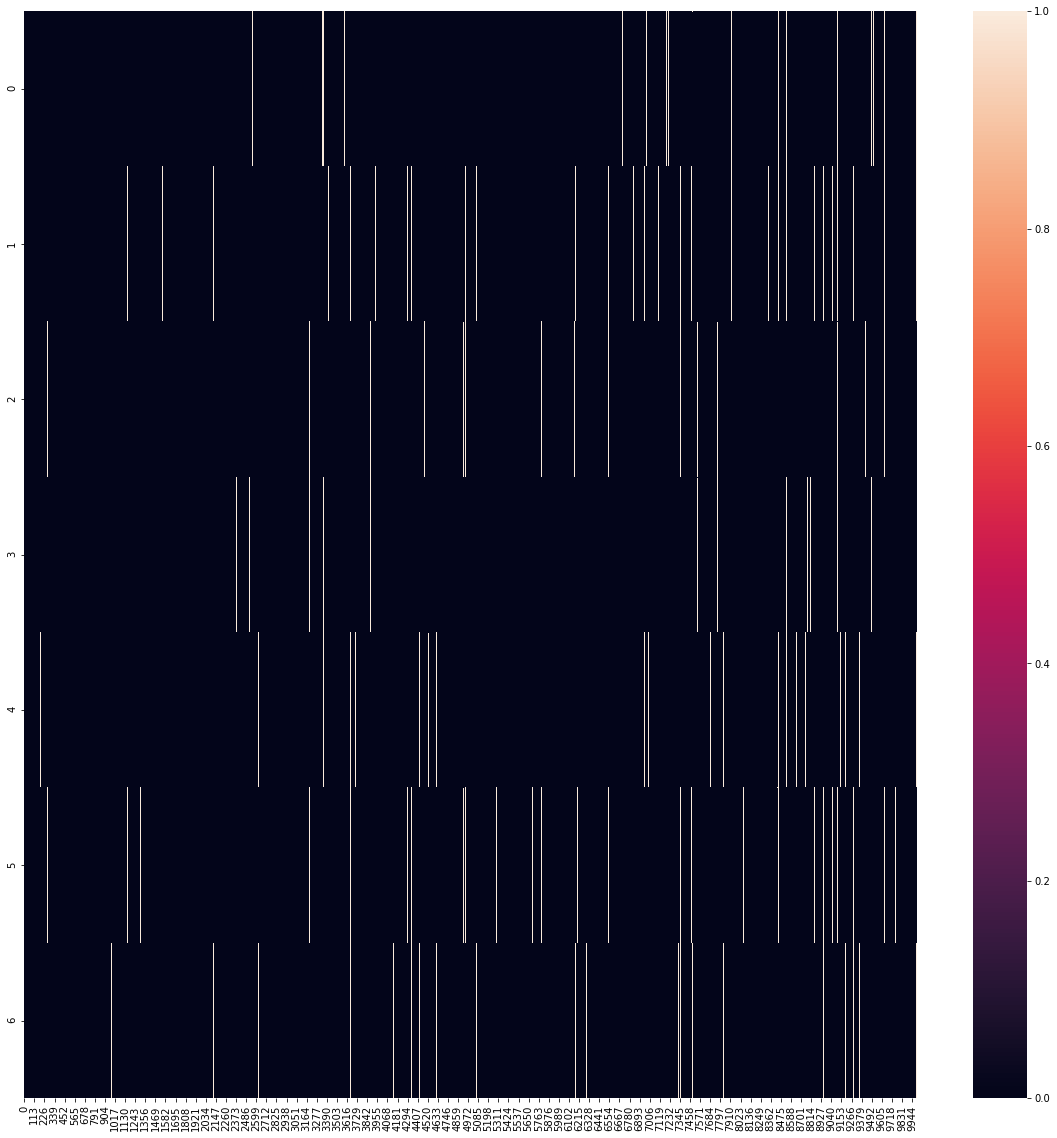

In [19]:
sns.heatmap(np.isnan(data[:int(1e4), CONFIG.channel_index[40, :7]]).T)

In [12]:
np.isnan(data[i-1000:i, ch]).sum()

39

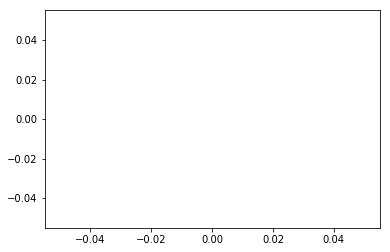

In [49]:
plt.plot(data[i-1000:i, ch])

In [31]:
n_noise = 1
temporal_size = 100
n_channels = 49

neigh_channels = np.ones((n_channels, n_channels))

(spatial_sig,
 temporal_sig) = (noise_utils.
                  noise_cov(path_to_standarized,
                            neigh_channels,
                            CONFIG.geom, temporal_size))

In [32]:
noise = augment_util.make_noise((1, temporal_size, n_channels),
                                spatial_sig,
                                temporal_sig)

print('Noise shape:', noise.shape)

Noise shape: (1, 100, 49)


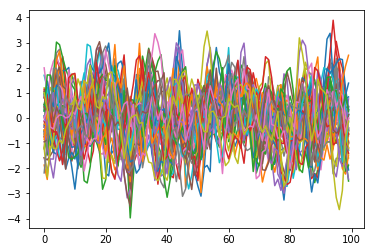

In [34]:
_ = plt.plot(noise[0, :, :])

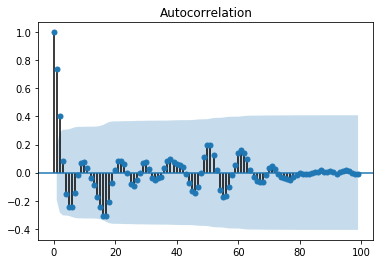

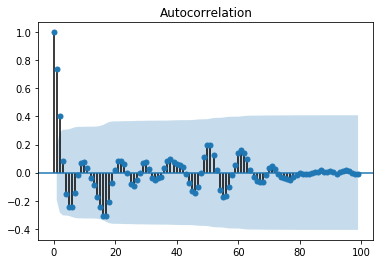

In [39]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(noise[0, :, 4])

In [41]:
from yass import detect
CONFIG.detect

********** start of YASS configuration file **********
Content: {   'if_file_exists': 'skip',
    'method': 'nn',
    'neural_network_autoencoder': {   'filename': '/home/Edu/dev/yass/src/yass/assets/models/ae_nn1.ckpt'},
    'neural_network_detector': {   'filename': '/home/Edu/dev/yass/src/yass/assets/models/detect_nn1.ckpt',
                                   'threshold_spike': 0.5},
    'neural_network_triage': {   'filename': '/home/Edu/dev/yass/src/yass/assets/models/triage_nn1.ckpt',
                                 'threshold_collision': 0.5},
    'save_results': False,
    'temporal_features': 3,
    'threshold_detector': {'std_factor': 4}}
********** end of YASS configuration file **********

In [70]:
import yaml

noise = augment_util.make_noise((1, temporal_size, n_channels),
                                spatial_sig,
                                temporal_sig)

print(noise.shape)

params = {'data_order': 'samples', 'dtype': noise.dtype, 'n_channels': 49}
noise.tofile('/tmp/noise.bin')

with open('/tmp/noise.yaml', 'w') as f:
        yaml.dump(params, f)

(1, 100, 49)


In [71]:
scores, clear, spikes_all = detect.run('/tmp/noise.bin', '/tmp/noise.yaml', '/home/Edu/data/retinal/tmp/whitening.npy')

/home/Edu/dev/yass/src/yass/neuralnetwork/model_triage.py:78: UserWarning: Network n_neighbors (7) does not match n_neighbors on input_tensor (19), using only the first n_neighbors from the input_tensor
  input_tensor.shape[2]))



  0%|          | 0/1 [00:00<?, ?it/s]

ValueError: zero-size array to reduction operation maximum which has no identity

In [ ]:
spikes_all.shape

## Misclassified noise with varying amplitudes

In [51]:
spikes_all.shape

(943, 2)

In [21]:
noise_df = dataset.get_kind('noise', units_per_bin=0.5).df

# add labels
_ = {'noise': 0}

noise_df['label'] = noise_df.kind.replace(_)

noise_df.head()

,waveform,amplitude,kind,ptp,amplitude_group,ptp_group,label
0,"[[-1.6253783266469422, -1.5959699571525172, -0...",3.270871,noise,5.740795,3.402,5.996,0
1,"[[0.8933451262495634, 1.3945482719287874, -0.4...",3.600292,noise,5.566861,5.531,5.685,0
2,"[[0.28290094981448327, 0.014502642479849788, -...",2.861839,noise,5.535055,2.866,5.685,0
3,"[[-0.897027124133813, 1.0607881774081525, -0.2...",2.676393,noise,4.852796,2.727,4.895,0
4,"[[-1.2232362210149863, -1.7543754432971572, -0...",3.053520,noise,4.871959,3.168,4.895,0


/home/Edu/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


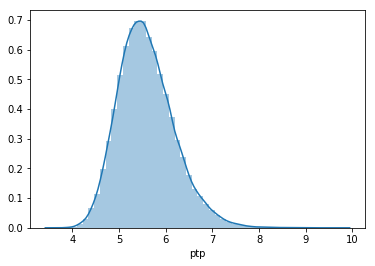

In [37]:
sns.distplot(noise_df.ptp)

In [45]:
def prop(preds, group):
    return (1 - (preds == group.label).mean())

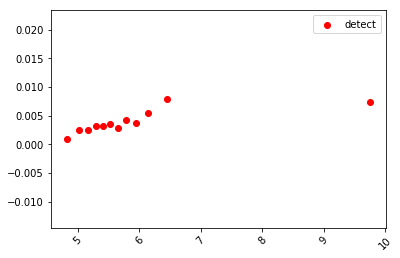

In [46]:
x, y = evaluate.compute_per_group(noise_df, 'ptp_group',
                                  model.predict, prop)

# plot results
# label=model.model_name
_ = plt.scatter(x, y, color='r', label='detect')

_ = plt.legend()
_ = plt.xticks(rotation=45)

## Predict on recordings

## Metrics vs SNR

In [75]:
dataset.get_kind('from templates').data.shape

(168000, 61, 7)

In [86]:
dataset.stats

{'from templates': 168000, 'noise': 168000}

In [76]:
df = dataset.df
df['label'] = df.kind.replace({'from templates': 1, 'noise': 0})
df.head()

,waveform,amplitude,kind,ptp,amplitude_group,ptp_group,label
0,"[[-0.2197098131141625, 0.27818156690928486, -0...",3.864613,from templates,6.324316,3.906,6.325,1
1,"[[1.5419701613861303, -0.7821495753196137, 0.9...",3.340473,from templates,6.396809,3.348,6.427,1
2,"[[0.868285967790336, 0.43162241559360454, 2.13...",3.723993,from templates,5.818480,3.732,5.824,1
3,"[[-1.1838339811369352, -0.33491918626110256, -...",2.928016,from templates,5.739770,2.931,5.753,1
4,"[[-0.16253742875914945, -0.38721022237326364, ...",3.643534,from templates,6.877941,3.651,6.958,1


In [77]:
def acc(preds, group):
    return (preds == group.label.values).mean()

def accuracy(preds, group):
    return metrics.accuracy_score(group.label, preds)

In [81]:
from functools import partial

def predict_w_threshold(x, threshold):
    return model.predict_proba(x) > threshold

predict_ = partial(predict_w_threshold, threshold=THRESHOLD)
# predict_ = model.predict_proba

In [87]:
def plot_metric(metric, title):
    x, y = evaluate.compute_per_group(df,
                         'amplitude_group',
                         model.predict_classes if hasattr(model, 'predict_classes') else model.predict,
                         metric)    
    x_ref, y_ref = evaluate.compute_per_group(df,
                         'amplitude_group',
                         model_ref.predict_classes if hasattr(model_ref, 'predict_classes') else model_ref.predict,
                         metric)

    min_ = np.min(x)
    max_ = np.max(x)


    plt.figure(figsize=(20, 10))

    _ = plt.scatter(x, y, color='b', label='Detect new architecture')
    _ = plt.scatter(x_ref, y_ref, color='r', label='Detect reference')

    # _ = plt.hlines(1.0, 2, max_, linestyles='dashed')
    # _ = plt.hlines(0.98, 2, max_, linestyles='dashed')
    # _ = plt.hlines(0.9, 2, max_, linestyles='dashed')
    # _ = plt.vlines(2.5, 0.5, 1, linestyles='dashed')

#     _ = plt.xlim(2, 20)
    _ = plt.title(title)

    _ = plt.legend()
    _ = plt.xticks(rotation=45)

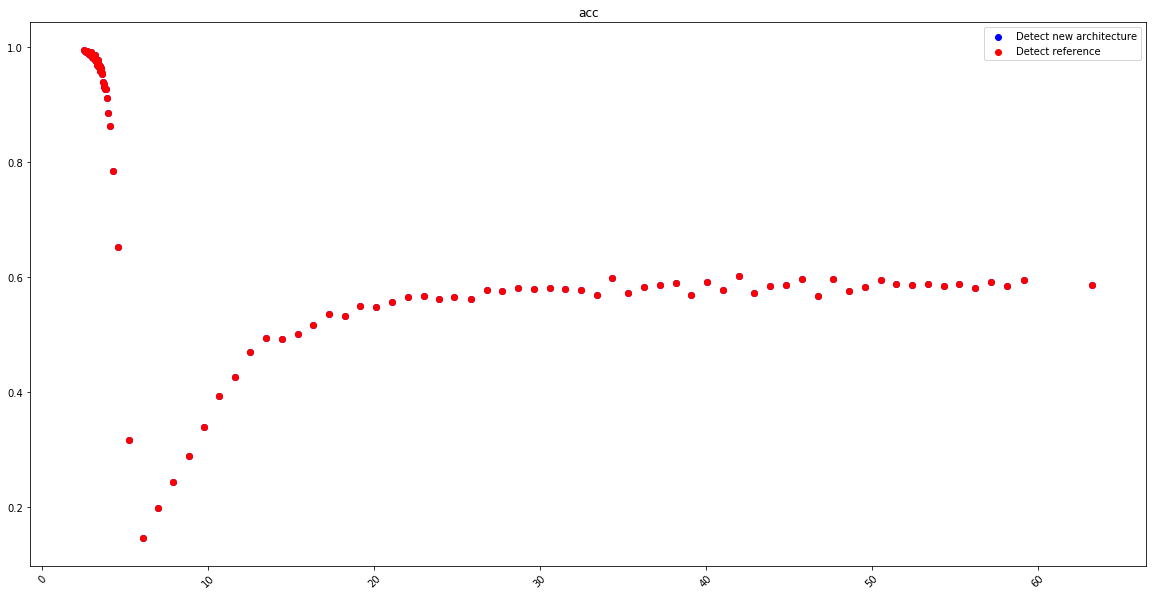

In [88]:
plot_metric(acc, 'acc')

In [47]:
from os import path

path_to_x = path.expanduser('~/x_detect_2_60.npy')
path_to_y = path.expanduser('~/y_detect_2_60.npy')

x_detect = np.load(path_to_x)
y_detect = np.load(path_to_y)

In [52]:
preds = model.predict_classes(x_detect[:, :, :, np.newaxis])

In [55]:
(np.squeeze(preds) == y_detect).mean()

0.993793536599292

In [ ]:
# from yass.augment import util as augment_util

# evaluate.to_data_frame(x_detect, augment_util.amplitudes(x_detect),
#                        augment_util.amplitudes(x_detect),
#                       slices )